In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
## Other imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  ConfusionMatrixDisplay,
)

In [9]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cpu


In [10]:
## Data loading

def load_data(path):
    df = pd.read_csv(path)
    X = df.drop("label", axis=1).to_numpy()
    Y = df["label"].to_numpy()
    return X, Y

# Training data
X, Y = load_data("train.csv")

# Test data
X_test = pd.read_csv("test.csv").to_numpy()

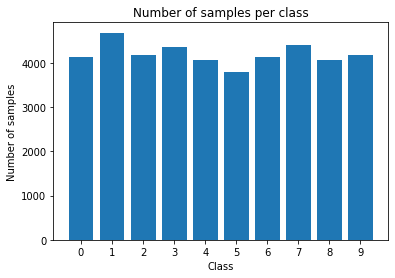

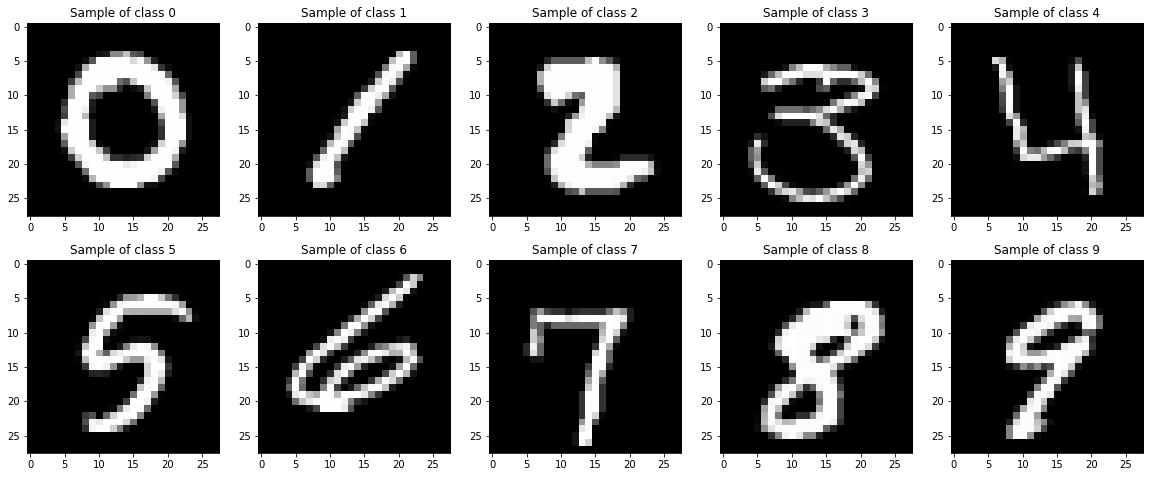

In [11]:
## Data exploration

# Plot the number of samples per class
labels, counts = np.unique(Y, return_counts=True)
plt.bar([str(label) for label in labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Number of samples per class")

# Plot one sample from each class
fig = plt.figure(figsize=[20, 8])
for label in labels:
    first_label_idx = np.where(Y == label)[0][0]
    ax = fig.add_subplot(2 , 5, label+1)
    ax.imshow(X[first_label_idx].reshape((28,28)), cmap="gray")
    ax.set_title(f"Sample of class {label}")

In [12]:
## Split training data into train and validation sets

def split_train_validation(data_length, percentage=0.8):
    shuffled_indices = np.random.permutation(data_length)
    n_train = round(data_length * percentage)
    idxs_train = shuffled_indices[:n_train]
    idxs_validation = shuffled_indices[n_train:]
    return idxs_train, idxs_validation

idxs_train, idxs_validation = split_train_validation(len(Y))
X_train, Y_train = X[idxs_train], Y[idxs_train]
X_validation, Y_validation = X[idxs_validation], Y[idxs_validation]

In [13]:
## Create PyTorch datasets

class DigitDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __getitem__(self, idx):
        x = self.X[idx].reshape(28,28)
        y = self.Y[idx]
        
        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.X)

transform = transforms.ToTensor()
train_dataset = DigitDataset(X_train, Y_train, transform)
validation_dataset = DigitDataset(X_validation, Y_validation, transform)
combined_dataset = DigitDataset(X, Y, transform)

In [14]:
## LeNet inspired network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.feature_extraction_layers = nn.Sequential( # Input dim = (batch_size, 1, 28, 28)
            nn.Conv2d(1, 6, kernel_size=5), # Output dim = (batch_size, 6, 24, 24)
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output dim = (batch_size, 6, 12, 12)
            nn.Conv2d(6, 16, kernel_size=5), # Output dim = (batch_size, 16, 8, 8)
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.classification_layer = nn.Sequential(
            nn.Linear(1024, 600),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(600, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 10),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = self.feature_extraction_layers(x)
        x = torch.flatten(x, 1)
        x = self.classification_layer(x)
        return x

In [15]:
## Network training

def train_model(model, criterion, optimizer, batch_size, dataset):
    dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        loss_curve = []

        for X, Y in dataloader:
            optimizer.zero_grad()

            X = X.to(device)
            Y = Y.to(device)

            # Forward pass
            Y_predicted = model(X)
            loss = criterion(Y_predicted, Y)
            loss_curve += [loss.item()]

            # Backward pass
            loss.backward()
            optimizer.step()

        print(f"--- Iteration {epoch+1}: training loss = {np.array(loss_curve).mean():.4f} ---")

# Define the parameters
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_batch_size = 100
epochs = 20

train_model(model, criterion, optimizer, train_batch_size, train_dataset)

  5%|▌         | 1/20 [00:16<05:22, 16.98s/it]

--- Iteration 1: training loss = 1.5814 ---


 10%|█         | 2/20 [00:34<05:10, 17.26s/it]

--- Iteration 2: training loss = 1.4953 ---


 15%|█▌        | 3/20 [00:49<04:37, 16.33s/it]

--- Iteration 3: training loss = 1.4883 ---


 20%|██        | 4/20 [01:02<03:59, 14.99s/it]

--- Iteration 4: training loss = 1.4820 ---


 25%|██▌       | 5/20 [01:20<03:58, 15.87s/it]

--- Iteration 5: training loss = 1.4800 ---


 30%|███       | 6/20 [01:36<03:47, 16.24s/it]

--- Iteration 6: training loss = 1.4790 ---


 35%|███▌      | 7/20 [01:59<03:57, 18.30s/it]

--- Iteration 7: training loss = 1.4799 ---


 40%|████      | 8/20 [02:16<03:33, 17.80s/it]

--- Iteration 8: training loss = 1.4778 ---


 45%|████▌     | 9/20 [02:41<03:41, 20.11s/it]

--- Iteration 9: training loss = 1.4761 ---


 50%|█████     | 10/20 [03:00<03:19, 19.91s/it]

--- Iteration 10: training loss = 1.4761 ---


 55%|█████▌    | 11/20 [03:26<03:13, 21.50s/it]

--- Iteration 11: training loss = 1.4768 ---


 60%|██████    | 12/20 [03:51<03:01, 22.71s/it]

--- Iteration 12: training loss = 1.4742 ---


 65%|██████▌   | 13/20 [04:13<02:37, 22.49s/it]

--- Iteration 13: training loss = 1.4740 ---


 70%|███████   | 14/20 [04:42<02:27, 24.60s/it]

--- Iteration 14: training loss = 1.4737 ---


 75%|███████▌  | 15/20 [05:03<01:57, 23.50s/it]

--- Iteration 15: training loss = 1.4735 ---


 80%|████████  | 16/20 [05:21<01:27, 21.81s/it]

--- Iteration 16: training loss = 1.4730 ---


 85%|████████▌ | 17/20 [05:40<01:02, 20.94s/it]

--- Iteration 17: training loss = 1.4761 ---


 90%|█████████ | 18/20 [05:59<00:40, 20.44s/it]

--- Iteration 18: training loss = 1.4737 ---


 95%|█████████▌| 19/20 [06:19<00:20, 20.12s/it]

--- Iteration 19: training loss = 1.4731 ---


100%|██████████| 20/20 [06:38<00:00, 19.94s/it]

--- Iteration 20: training loss = 1.4728 ---


In [16]:
## Deploy model on validation set

validation_dataloader = DataLoader(dataset=validation_dataset)

predicted = []
actual = []
with torch.no_grad():
    model.eval()
    
    for x, y in tqdm(validation_dataloader):
        x = x.to(device)
        y = y.detach().numpy()
        
        label_probabilities = model(x).cpu().detach().numpy()
        label_predicted = np.argmax(label_probabilities)
        
        predicted.append(label_predicted)
        actual.append(y)

predicted = np.array(predicted)
actual = np.array(actual)

100%|██████████| 8400/8400 [00:21<00:00, 384.86it/s]


Accuracy: 0.9838095238095238
Precision scores (index corresponds to class): [0.98867925 0.9943757  0.96228571 0.97734994 0.98083832 0.98943197
 0.98566308 0.98725377 0.99025579 0.98343195]
Recall scores (index corresponds to class): [0.99619772 0.99325843 0.99058824 0.98403649 0.99032648 0.97272727
 0.99277978 0.98043728 0.97132616 0.96627907]
F1 scores (index corresponds to class): [0.99242424 0.99381675 0.97623188 0.98068182 0.98555957 0.98100851
 0.98920863 0.98383372 0.98069964 0.97478006]


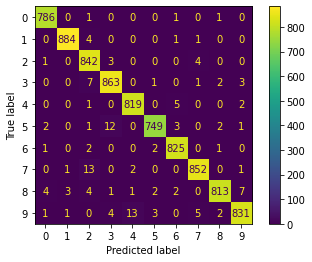

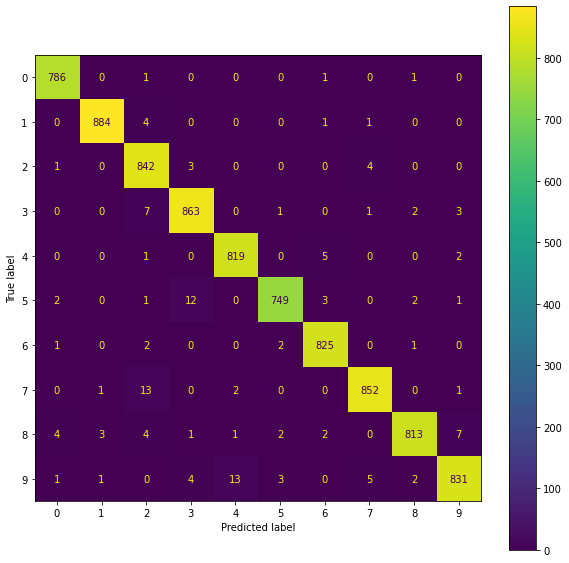

In [17]:
## Evaluate on evaluation set

# Compute performance metrics
print(f"Accuracy: { accuracy_score(actual, predicted)}")
print(f"Precision scores (index corresponds to class): {precision_score(actual, predicted, average=None)}")
print(f"Recall scores (index corresponds to class): {recall_score(actual, predicted, average=None)}")
print(f"F1 scores (index corresponds to class): {f1_score(actual, predicted, average=None)}")

# Visualize the confusion matrix
cmp = ConfusionMatrixDisplay.from_predictions(actual, predicted)
_, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [18]:
## Train on combined training and validation data + deploy on test data

train_model(model, criterion, optimizer, train_batch_size, combined_dataset)

# Deploy on test data
predicted = []
with torch.no_grad():
    model.eval()
    
    for x in tqdm(X_test):
        x = x.reshape(28,28)
        x = Image.fromarray(x.astype(np.uint8))
        x = transform(x).unsqueeze(0).to(device)
        
        label_probabilities = model(x).cpu().detach().numpy()
        label_predicted = np.argmax(label_probabilities)
        
        predicted.append(label_predicted)

# Save test predictions for submission
labels = pd.Series(predicted, name="Label")
submission = pd.concat([pd.Series(range(1,len(X_test)+1), name="ImageId"), labels], axis=1)
submission.to_csv("digit_recognizer_submission.csv", index=False)

  5%|▌         | 1/20 [00:19<06:04, 19.20s/it]

--- Iteration 1: training loss = 1.4739 ---


 10%|█         | 2/20 [00:39<05:58, 19.93s/it]

--- Iteration 2: training loss = 1.4718 ---


 15%|█▌        | 3/20 [00:59<05:40, 20.03s/it]

--- Iteration 3: training loss = 1.4744 ---


 20%|██        | 4/20 [01:19<05:19, 19.98s/it]

--- Iteration 4: training loss = 1.4754 ---


 25%|██▌       | 5/20 [01:39<04:57, 19.86s/it]

--- Iteration 5: training loss = 1.4716 ---


 30%|███       | 6/20 [01:59<04:41, 20.12s/it]

--- Iteration 6: training loss = 1.4730 ---


 35%|███▌      | 7/20 [02:19<04:21, 20.08s/it]

--- Iteration 7: training loss = 1.4724 ---


 40%|████      | 8/20 [02:38<03:56, 19.73s/it]

--- Iteration 8: training loss = 1.4709 ---


 45%|████▌     | 9/20 [02:58<03:34, 19.52s/it]

--- Iteration 9: training loss = 1.4714 ---


 50%|█████     | 10/20 [03:17<03:15, 19.53s/it]

--- Iteration 10: training loss = 1.4720 ---


 55%|█████▌    | 11/20 [03:35<02:52, 19.19s/it]

--- Iteration 11: training loss = 1.4720 ---


 60%|██████    | 12/20 [03:54<02:31, 18.95s/it]

--- Iteration 12: training loss = 1.4725 ---


 65%|██████▌   | 13/20 [04:13<02:12, 18.95s/it]

--- Iteration 13: training loss = 1.4713 ---


 70%|███████   | 14/20 [04:31<01:52, 18.68s/it]

--- Iteration 14: training loss = 1.4716 ---


 75%|███████▌  | 15/20 [04:49<01:32, 18.44s/it]

--- Iteration 15: training loss = 1.4720 ---


 80%|████████  | 16/20 [05:07<01:13, 18.28s/it]

--- Iteration 16: training loss = 1.4736 ---


 85%|████████▌ | 17/20 [05:26<00:55, 18.60s/it]

--- Iteration 17: training loss = 1.4724 ---


 90%|█████████ | 18/20 [05:45<00:37, 18.79s/it]

--- Iteration 18: training loss = 1.4718 ---


 95%|█████████▌| 19/20 [06:02<00:18, 18.32s/it]

--- Iteration 19: training loss = 1.4732 ---


100%|██████████| 20/20 [06:23<00:00, 19.18s/it]


--- Iteration 20: training loss = 1.4719 ---


100%|██████████| 28000/28000 [01:06<00:00, 421.10it/s]
